###Importing Headers

In [71]:
import pandas as pd
from pandas import read_excel
import numpy as np
import re
from re import sub
import multiprocessing
import os
from time import time
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Activation,Embedding,Flatten,Bidirectional,MaxPooling2D, Conv1D, MaxPooling1D
from keras.optimizers import SGD,Adam
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import h5py
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import string

###Predefined Functions

In [72]:
def text_to_word_list(text):
    text = text.split()
    return text

def replace_strings(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\u00C0-\u017F"          #latin
                           u"\u2000-\u206F"          #generalPunctuations

                           "]+", flags=re.UNICODE)
    english_pattern=re.compile('[a-zA-Z0-9]+', flags=re.I)
    #latin_pattern=re.compile('[A-Za-z\u00C0-\u00D6\u00D8-\u00f6\u00f8-\u00ff\s]*',)

    text=emoji_pattern.sub(r'', text)
    text=english_pattern.sub(r'', text)

    return text

def remove_punctuations(my_str):
    # define punctuation
    punctuations = '''````£|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰⚽️✌�￰৷￰'''

    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char

    # display the unpunctuated string
    return no_punct


def joining(text):
    out=' '.join(text)
    return out

def preprocessing(text):
    out=remove_punctuations(replace_strings(text))
    return out

###Importing Data

In [73]:
df=pd.read_excel('predicted_unsupervised_sentiment.xlsx')
display(df)

,Unnamed: 0,Unnamed: 1,Unnamed: 2,sentence,sentiment
0,0,NaN,NaN,ওয়ও আমি গর্বিত বাঙ্গালি,1
1,1,NaN,NaN,বাংলাদেশ এর কিছু মানুষ নিজে কিছু করতে পারবেনা ...,0
2,2,NaN,NaN,রামোসের ঘুম আসে না,0
3,3,NaN,NaN,কোহলির প্রতি শ্রদ্ধা হারিয়ে ফেলছি,1
4,4,NaN,NaN,থ্যাঙ্ক ইউ মাছরাঙ্গা টেলিভিশনকিন্তু ছাপোষা আন্...,0
...,...,...,...,...,...
6647,6647,NaN,NaN,আমি কখনো আশা করিনি যে আমি আমার স্বপ্নের প্রিয় ...,1
6648,6648,NaN,NaN,মিডিয়া লিটনকে একজন খারাপ মানুষ হিসেবে প্রতিষ্ঠ...,0
6649,6649,NaN,NaN,বাংলাদেশের জন্ম কিংবা তার পূর্বের ইতিহাস অনেকে...,0
6650,6650,NaN,NaN,আপনারা সিম নিবন্দন করালেন বাংলাদেশে অপরাধ কমবে...,0


In [74]:
df.dropna()
df = df.drop(['Unnamed: 1'], axis = 1)
df = df.drop(['Unnamed: 2'], axis = 1)
df

,Unnamed: 0,sentence,sentiment
0,0,ওয়ও আমি গর্বিত বাঙ্গালি,1
1,1,বাংলাদেশ এর কিছু মানুষ নিজে কিছু করতে পারবেনা ...,0
2,2,রামোসের ঘুম আসে না,0
3,3,কোহলির প্রতি শ্রদ্ধা হারিয়ে ফেলছি,1
4,4,থ্যাঙ্ক ইউ মাছরাঙ্গা টেলিভিশনকিন্তু ছাপোষা আন্...,0
...,...,...,...
6647,6647,আমি কখনো আশা করিনি যে আমি আমার স্বপ্নের প্রিয় ...,1
6648,6648,মিডিয়া লিটনকে একজন খারাপ মানুষ হিসেবে প্রতিষ্ঠ...,0
6649,6649,বাংলাদেশের জন্ম কিংবা তার পূর্বের ইতিহাস অনেকে...,0
6650,6650,আপনারা সিম নিবন্দন করালেন বাংলাদেশে অপরাধ কমবে...,0


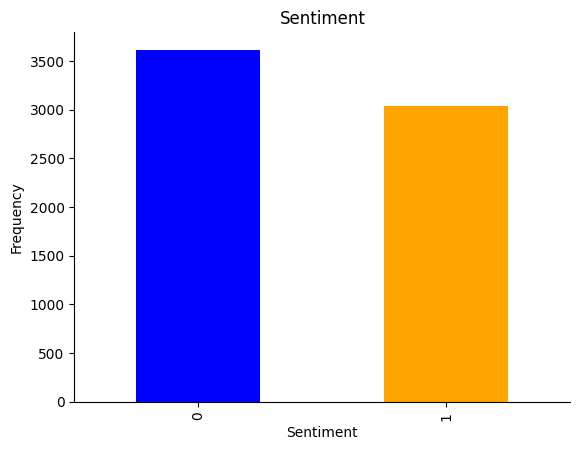

In [75]:
import pandas as pd
from matplotlib import pyplot as plt

# Assuming df is your DataFrame and 'sentiment' is the column name
df_filtered = df[df['sentiment'].isin([0, 1])]

# Count the occurrences of each sentiment
sentiment_counts = df_filtered['sentiment'].value_counts().sort_index()

colors = ['blue', 'orange']

# Plot as bar chart with specified colors
sentiment_counts.plot(kind='bar', color=colors, title='Sentiment')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xticks([0, 1], ['0', '1'])  # Ensure only 0 and 1 appear on the x-axis
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()


###Data Preprocessing

In [76]:
df['sentence'] = df.sentence.apply(lambda x: preprocessing(str(x)))
df.reset_index(drop=True, inplace=True)

###Train and Test Separating

In [77]:
train1, test1 = train_test_split(df,random_state=69, test_size=0.2)
training_sentences = []
testing_sentences = []



train_sentences=train1['sentence'].values
train_labels=train1['sentiment'].values
for i in range(train_sentences.shape[0]):
    x=str(train_sentences[i])
    training_sentences.append(x)

training_sentences=np.array(training_sentences)

test_sentences=test1['sentence'].values
test_labels=test1['sentiment'].values

for i in range(test_sentences.shape[0]):
    x=str(test_sentences[i])
    testing_sentences.append(x)

testing_sentences=np.array(testing_sentences)


train_labels=keras.utils.to_categorical(train_labels)


test_labels=keras.utils.to_categorical(test_labels)
print("Training Set Length: "+str(len(train1)))
print("Testing Set Length: "+str(len(test1)))
print("training_sentences shape: "+str(training_sentences.shape))
print("testing_sentences shape: "+str(testing_sentences.shape))
print("train_labels shape: "+str(train_labels.shape))
print("test_labels shape: "+str(test_labels.shape))

Training Set Length: 5321
Testing Set Length: 1331
training_sentences shape: (5321,)
testing_sentences shape: (1331,)
train_labels shape: (5321, 2)
test_labels shape: (1331, 2)


In [78]:
print(training_sentences[1])
print(train_labels[0])
print(testing_sentences[1])
print(test_labels[0])

দেশের প্রধান যে সেই করছে অপরাধ তোমরা সিম নিয়ে অপরাধ বন্ধ করবে পাগল যত সব
[1. 0.]
এই শালায় একটা মিথ্যুক আর যারা তার সাক্ষাৎকার ছাপিয়েছে তারা আরও বড় মিথ্যুক
[0. 1.]


In [79]:
# Assuming all preprocessing functions and data loading are already done
# df = ... # Your DataFrame loading and preprocessing steps

# Tokenize the text
max_words = 10000  # Max number of words to use (most frequent)
max_len = 100  # Max length of each sentence

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(training_sentences)

train_sequences = tokenizer.texts_to_sequences(training_sentences)
test_sequences = tokenizer.texts_to_sequences(testing_sentences)

train_padded = pad_sequences(train_sequences, maxlen=max_len)
test_padded = pad_sequences(test_sequences, maxlen=max_len)

# Define the model
model = Sequential()
model.add(Embedding(max_words, 128, input_length=max_len))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_padded, train_labels,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(test_padded, test_labels)
print(f'Test Accuracy: {accuracy:.4f}')


Epoch 1/10
133/133 [==============================] - 15s 104ms/step - loss: 0.5756 - accuracy: 0.6809 - val_loss: 0.4159 - val_accuracy: 0.8056
Epoch 2/10
133/133 [==============================] - 13s 98ms/step - loss: 0.1958 - accuracy: 0.9229 - val_loss: 0.3741 - val_accuracy: 0.8498
Epoch 3/10
133/133 [==============================] - 9s 67ms/step - loss: 0.0406 - accuracy: 0.9885 - val_loss: 0.5520 - val_accuracy: 0.8554
Epoch 4/10
133/133 [==============================] - 11s 80ms/step - loss: 0.0119 - accuracy: 0.9977 - val_loss: 0.6954 - val_accuracy: 0.8441
Epoch 5/10
133/133 [==============================] - 11s 79ms/step - loss: 0.0066 - accuracy: 0.9981 - val_loss: 0.7889 - val_accuracy: 0.8432
Epoch 6/10
133/133 [==============================] - 10s 74ms/step - loss: 0.0017 - accuracy: 0.9995 - val_loss: 0.8512 - val_accuracy: 0.8498
Epoch 7/10
133/133 [==============================] - 10s 72ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 0.8792 - val_accuracy:

In [80]:
# Predict the sentiment for the test data
predictions = model.predict(test_padded)

# Convert the predictions from one-hot encoding to label (0 or 1)
predicted_labels = np.argmax(predictions, axis=1)

# Convert the true labels from one-hot encoding to label (0 or 1)
true_labels = np.argmax(test_labels, axis=1)

# Print a few predictions along with their true labels
for i in range(10):  # Change 10 to any number to see more/less predictions
    print(f"Predicted: {predicted_labels[i]}, True: {true_labels[i]}")

# Optional: If you want to save the predictions to a CSV file
output_df = pd.DataFrame({'sentence': test1['sentence'], 'true_sentiment': true_labels, 'predicted_sentiment': predicted_labels})
output_df.to_csv('predictions.csv', index=False)


42/42 [==============================] - 1s 15ms/step
Predicted: 0, True: 1
Predicted: 1, True: 1
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 1, True: 1
Predicted: 0, True: 0
Predicted: 1, True: 1
Predicted: 0, True: 0
Predicted: 1, True: 1


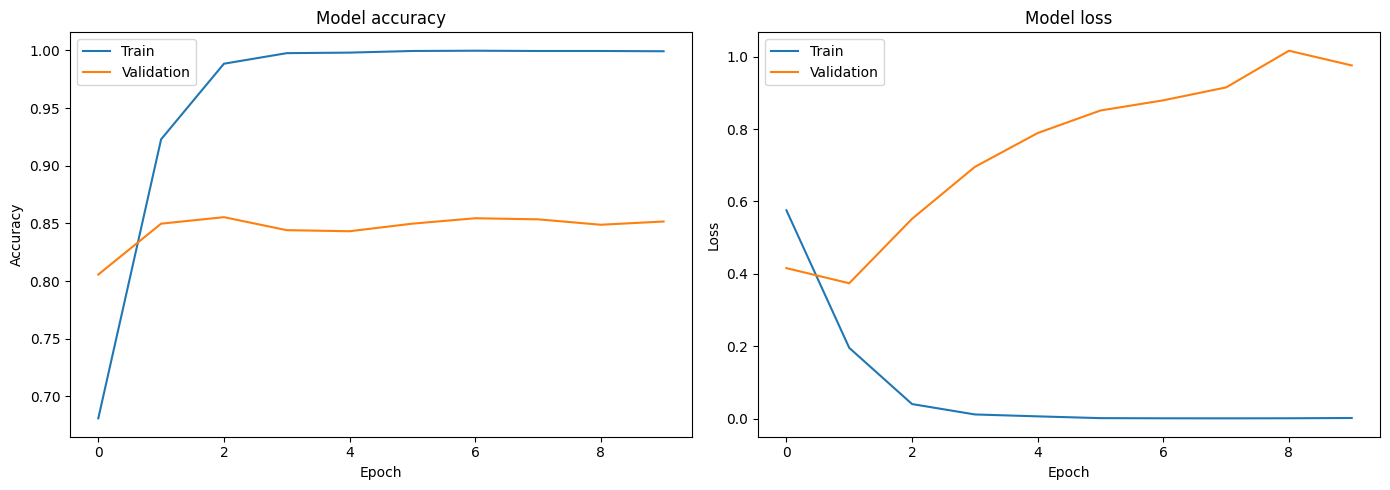

In [81]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [82]:
loss_and_metrics = model.evaluate(train_padded,train_labels,batch_size=32)
print("The train accuracy is: "+str(loss_and_metrics[1]))
loss_and_metrics = model.evaluate(test_padded,test_labels,batch_size=32)
print("The test accuracy is: "+str(loss_and_metrics[1]))

167/167 [==============================] - 4s 25ms/step - loss: 0.1960 - accuracy: 0.9701
The train accuracy is: 0.9701184034347534
42/42 [==============================] - 1s 14ms/step - loss: 1.0496 - accuracy: 0.8520
The test accuracy is: 0.8519909977912903
